# Introduction 

Ce projet concerne le Travail de Bachelor sur l'analyse de données en temps réel sur l'arbitrage du light-contact boxing. Le but est de signaler en temps réel les divergences de points attribués par les juges.


## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats as stats
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

## Data exploration
Chargement du fichier CSV LCBA_scores.csv

Voici une visualisation du match_id 21096

In [2]:
data = pd.read_csv('LCBA_scores.csv')

cols_to_display = ['score_id', 'red_point','red_penalty', 'blue_point','blue_penalty', 'date_create_app', 'judge_id', 'match_id']
data[cols_to_display]

,score_id,red_point,red_penalty,blue_point,blue_penalty,date_create_app,judge_id,match_id
0,1,0,0,0,0,NaN,114816,21089
1,2,0,0,0,0,NaN,114822,21089
2,3,0,0,0,0,NaN,114824,21089
3,4,0,0,0,0,NaN,114826,21093
4,5,0,0,0,0,NaN,114813,21093
...,...,...,...,...,...,...,...,...
38778,38952,1,0,0,0,2023-04-15 14:18:52.2+00,115226,22514
38779,38953,1,0,0,0,2023-04-15 14:18:51.485+00,114927,22514
38780,38954,1,0,0,0,2023-04-15 14:18:56.33+00,114927,22514
38781,38955,1,0,0,0,2023-04-15 14:18:56.889+00,114926,22514


Colonne red_point

In [3]:
data.red_point.describe()

count    38783.000000
mean         0.456102
std          0.561632
min         -3.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: red_point, dtype: float64

Colonne blue_point

In [4]:
data.blue_point.describe()

count    38783.000000
mean         0.457288
std          0.556790
min         -3.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: blue_point, dtype: float64

Colonne date_create_app

In [5]:
data.date_create_app.describe()

count                          36786
unique                         36782
top       2022-06-18 12:36:59.029+00
freq                               2
Name: date_create_app, dtype: object

On voit qu'il existe des valeurs null et négatives, quelques modifications/correction sonz apporter.
Nous allons prémièrement se concentrer sur un seul match_id.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38783 entries, 0 to 38782
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   score_id                  38783 non-null  int64  
 1   red_penalty               38783 non-null  int64  
 2   red_point                 38783 non-null  int64  
 3   blue_penalty              38783 non-null  int64  
 4   blue_point                38783 non-null  int64  
 5   date_create               38783 non-null  object 
 6   date_change               38783 non-null  object 
 7   judge_id                  38783 non-null  int64  
 8   match_id                  38783 non-null  int64  
 9   date_create_app           36786 non-null  object 
 10  uuid                      36786 non-null  object 
 11  judge_club_id             38783 non-null  int64  
 12  match_id.1                38783 non-null  int64  
 13  PalmaresDate              38783 non-null  object 
 14  winner

## Data preparation

### Conversion date
On constate qu'il considère les format de date comme des objets. On les convertit pour pour faciliter les prochains calculs sur la série temporelle. Le datetime64[ns] est un type de données utilisé dans Pandas pour représenter les dates et heures avec une précision jusqu'à la nanoseconde. 

In [7]:
cols_to_convert = ['date_create', 'date_change','date_create_app','PalmaresDate','PalmaresRealEndTime','PalmaresRealStartTime','open_time']
data[cols_to_convert] = data[cols_to_convert].apply(pd.to_datetime)

### Suppresion des colonnes null

In [8]:
null_rows = data[data['date_create_app'].isnull()]

cols_to_display2 = ['score_id', 'red_point', 'blue_point', 'judge_id', 'date_create_app']
print(null_rows[cols_to_display2])

# Supprimer les lignes
data = data.dropna(subset=['date_create_app'])

       score_id  red_point  blue_point  judge_id date_create_app
0             1          0           0    114816             NaT
1             2          0           0    114822             NaT
2             3          0           0    114824             NaT
3             4          0           0    114826             NaT
4             5          0           0    114813             NaT
...         ...        ...         ...       ...             ...
38639     38813          0           0    114927             NaT
38640     38814          0           0    114926             NaT
38711     38885          0           0    114927             NaT
38712     38886          0           0    114926             NaT
38713     38887          0           0    115226             NaT

[1997 rows x 5 columns]


## Modelling
### Graphes

In [9]:
total_points = data.groupby("match_id")[["red_point", "blue_point"]].sum().reset_index()

print(total_points)

     match_id  red_point  blue_point
0       21089         30          26
1       21092         12          25
2       21093         21          32
3       21095         31          37
4       21096         33          34
..        ...        ...         ...
803     22511         11          26
804     22512         10          10
805     22513         41          25
806     22514         34          35
807     22515         25          25

[808 rows x 3 columns]


In [90]:
cols_to_display = ['score_id', 'red_point', 'red_penalty', 'blue_point', 'blue_penalty', 'date_create_app', 'judge_id', 'match_id']
match_data = data[data['match_id'] == 21096][cols_to_display]
print(match_data)


     score_id  red_point  red_penalty  blue_point  blue_penalty  \
392       393          0            0           1             0   
393       394          0            0          -1             0   
400       401          0            0           1             0   
401       402          1            0           0             0   
402       403          1            0           0             0   
..        ...        ...          ...         ...           ...   
478       479          1            0           0             0   
479       480          1            0           0             0   
480       481          0            0           1             0   
481       482          0            0           1             0   
482       483          1            0           0             0   

                     date_create_app  judge_id  match_id  
392 2021-06-26 11:43:43.749000+00:00    114819     21096  
393 2021-06-26 11:43:45.252000+00:00    114819     21096  
400 2021-06-26 11:

In [49]:
match_rows = data.loc[data['match_id'] == 21096]

scores_by_judge = match_rows.groupby(['match_id', 'judge_id']).sum()[['red_point', 'blue_point']]

print(scores_by_judge)

                   red_point  blue_point
match_id judge_id                       
21096    114813           13          16
         114819            9          11
         114826           11           7


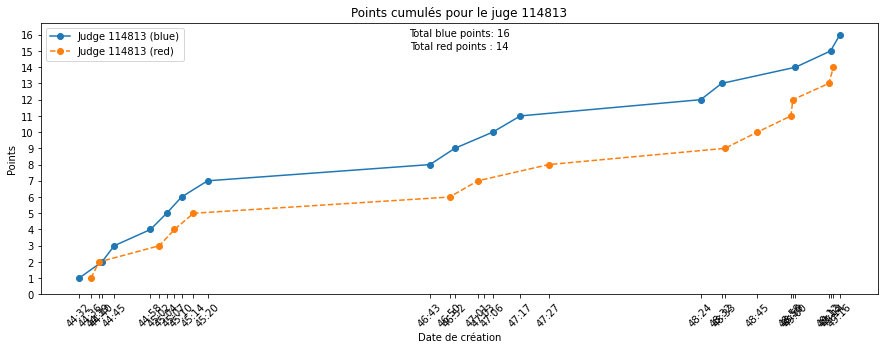

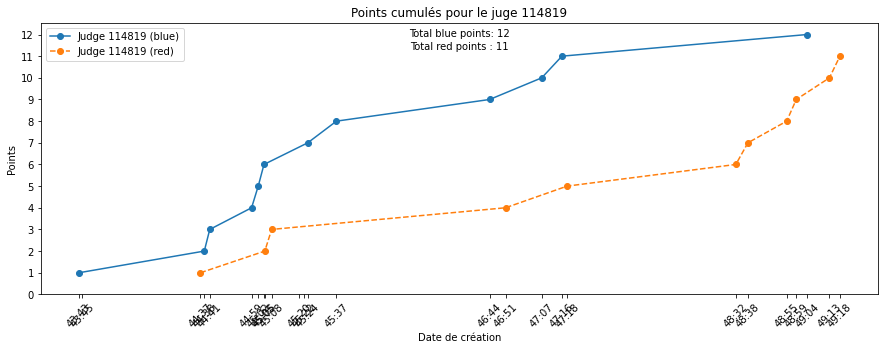

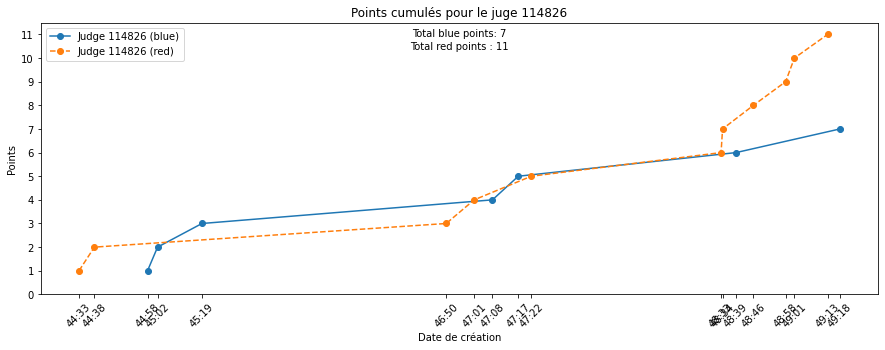

In [91]:
data = data[data['match_id'] == 21096]
data = data.sort_values('date_create_app')

data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]
data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]

grouped_data = data.groupby(['judge_id'])

# Boucle sur les groupes pour créer un graphe par judge_id
for name, group in grouped_data:
    group_blue_points = group[group['date_create_app'].isin(data_blue_points['date_create_app'])]
    group_red_points = group[group['date_create_app'].isin(data_red_points['date_create_app'])]

    cumulative_blue_points = group_blue_points['blue_point'].cumsum()
    cumulative_red_points = group_red_points['red_point'].cumsum()

    # Création d'un graphe pour chaque judge_id
    fig, axs = plt.subplots(figsize=(15, 5))
    
    axs.plot(group_blue_points['date_create_app'], cumulative_blue_points,marker='o', label=f"Judge {name} (blue)")
    axs.plot(group_red_points['date_create_app'], cumulative_red_points, marker='o',label=f"Judge {name} (red)", linestyle='--')

    # Configuration du graphe
    axs.set_xlabel("Date de création")
    axs.set_ylabel("Points")
    axs.legend()

    plt.xticks(rotation=45)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    axs.set_xticks(group['date_create_app'])
    axs.set_xticklabels(group['date_create_app'].dt.strftime('%M:%S'))

    max_points = max(cumulative_blue_points.max(), cumulative_red_points.max()) + 1
    axs.set_yticks(range(0, max_points))

    total_blue_points = group_blue_points['blue_point'].sum()
    axs.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=axs.transAxes, ha="center")

    total_red_points = group_red_points['red_point'].sum()
    axs.text(0.5, 0.9, f"Total red points : {total_red_points}", transform=axs.transAxes, ha="center")

    plt.title(f"Points cumulés pour le juge {name}")
    plt.show()

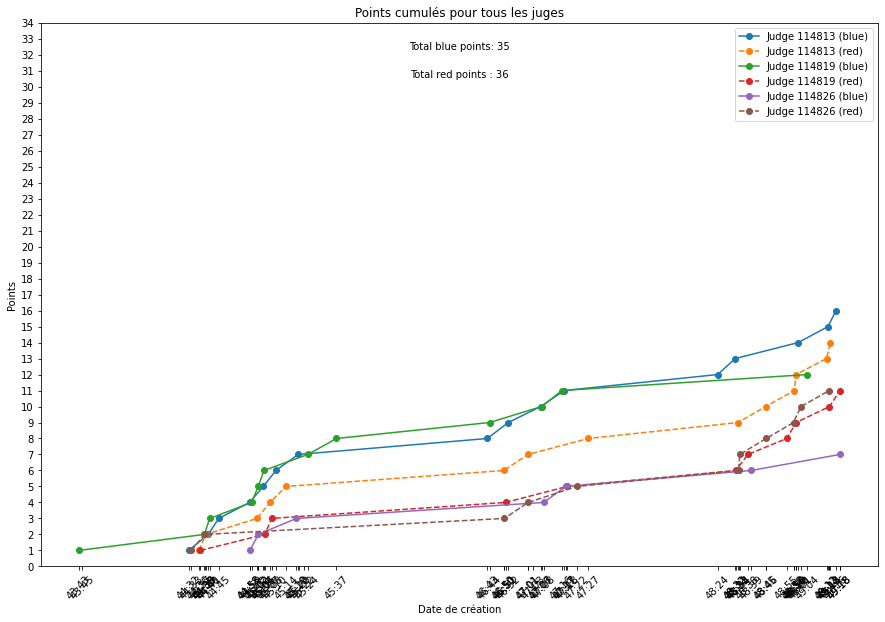

In [92]:
data = data[data['match_id'] == 21096]
data = data.sort_values('date_create_app')

data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]
data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]

grouped_data = data.groupby(['judge_id'])

# Création du graphe
fig, ax = plt.subplots(figsize=(15, 10))

# Boucle sur les groupes pour ajouter les points cumulés pour chaque juge
for name, group in grouped_data:
    group_blue_points = group[group['date_create_app'].isin(data_blue_points['date_create_app'])]
    group_red_points = group[group['date_create_app'].isin(data_red_points['date_create_app'])]

    cumulative_blue_points = group_blue_points['blue_point'].cumsum()
    cumulative_red_points = group_red_points['red_point'].cumsum()

    ax.plot(group_blue_points['date_create_app'], cumulative_blue_points, marker='o', label=f"Judge {name} (blue)")
    ax.plot(group_red_points['date_create_app'], cumulative_red_points, marker='o', label=f"Judge {name} (red)", linestyle='--')

# Configuration du graphe
ax.set_xlabel("Date de création")
ax.set_ylabel("Points")
ax.legend()

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

ax.set_xticks(data['date_create_app'])
ax.set_xticklabels(data['date_create_app'].dt.strftime('%M:%S'))

max_points = max(data['blue_point'].cumsum().max(), data['red_point'].cumsum().max()) + 1
ax.set_yticks(range(0, max_points))

total_blue_points = data_blue_points['blue_point'].sum()
ax.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=ax.transAxes, ha="center")

total_red_points = data_red_points['red_point'].sum()
ax.text(0.5, 0.9, f"Total red points : {total_red_points}", transform=ax.transAxes, ha="center")

plt.title(f"Points cumulés pour tous les juges")
plt.show()


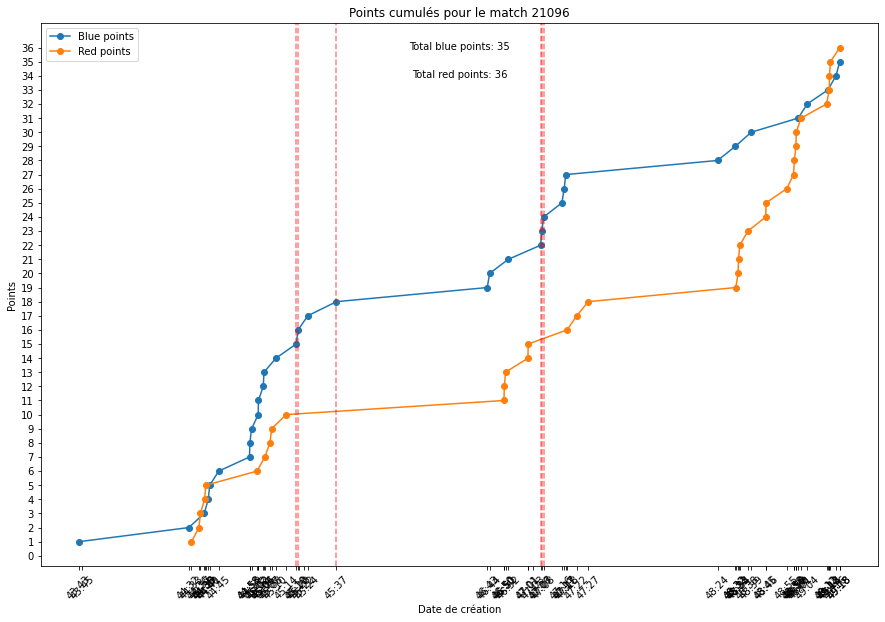

In [13]:
data = data[data['match_id'] == 21096]

data = data.sort_values('date_create_app')

data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]
data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]


cumulative_red_points = data_red_points['red_point'].cumsum()
cumulative_blue_points = data_blue_points['blue_point'].cumsum()

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(data_blue_points['date_create_app'], cumulative_blue_points, marker='o', label='Blue points')
ax.plot(data_red_points['date_create_app'], cumulative_red_points, marker='o', label='Red points')

red_penalty_dates = data[data['red_penalty'] == 1]['date_create_app']
for date in red_penalty_dates:
    ax.axvline(x=date, color='red', linestyle='--', alpha=0.5)

blue_penalty_dates = data[data['blue_penalty'] == 1]['date_create_app']
for date in blue_penalty_dates:
    ax.axvline(x=date, color='blue', linestyle='--', alpha=0.5)

# Configuration du graphe
ax.set_xlabel("Date de création")
ax.set_ylabel("Points")
ax.legend()

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

ax.set_xticks(data['date_create_app'])
ax.set_xticklabels(data['date_create_app'].dt.strftime('%M:%S'))

max_points = max(cumulative_blue_points.max(), cumulative_red_points.max()) + 1
ax.set_yticks(np.arange(0, max_points, 1))

total_blue_points = cumulative_blue_points.iloc[-1]
ax.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=ax.transAxes, ha="center")
total_red_points = cumulative_red_points.iloc[-1]
ax.text(0.5, 0.9, f"Total red points: {total_red_points}", transform=ax.transAxes, ha="center")

plt.title("Points cumulés pour le match 21096")
plt.show()

DBSCAN

Round 1
Score ID de la borne inférieure : 393
Score ID de la borne supérieure : 431

Round 2
Score ID de la borne inférieure : 437
Score ID de la borne supérieure : 454

Round 3
Score ID de la borne inférieure : 455
Score ID de la borne supérieure : 483



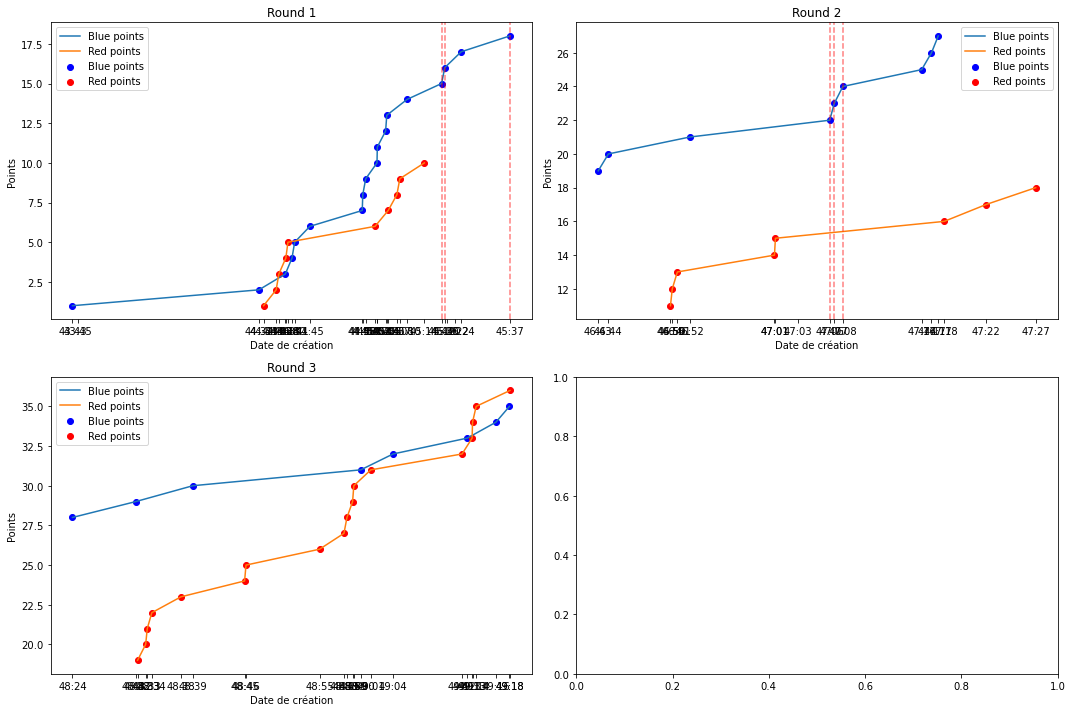

In [14]:
data['timestamp'] = data['date_create_app'].apply(lambda x: x.timestamp())

# Sélection des colonnes à utiliser pour le clustering
features = data[['timestamp']]
score_ids = data['score_id']

# Normalisation des caractéristiques
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Application de DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(normalized_features)

# Récupération des labels de cluster
labels = dbscan.labels_

# Récupération des indices des lignes pour chaque cluster
clusters = {}
for label in set(labels):
    if label != -1:  # Exclure la catégorie des outliers
        cluster_indices = [i for i, l in enumerate(labels) if l == label]
        lower_bound_index = min(cluster_indices)
        upper_bound_index = max(cluster_indices)
        lower_bound_score_id = score_ids.iloc[lower_bound_index]
        upper_bound_score_id = score_ids.iloc[upper_bound_index]
        clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                           'upper_bound_score_id': upper_bound_score_id}

# Affichage des bornes de chaque cluster
for label, bounds in clusters.items():
    print("Round", label+1)
    print("Score ID de la borne inférieure :", bounds['lower_bound_score_id'])
    print("Score ID de la borne supérieure :", bounds['upper_bound_score_id'])
    print()

# Filtrage des données pour les clusters sélectionnés
data_clusters = {}
for label, bounds in clusters.items():
    lower_bound_score_id = bounds['lower_bound_score_id']
    upper_bound_score_id = bounds['upper_bound_score_id']
    cluster_data = data[(data['score_id'] >= lower_bound_score_id) & (data['score_id'] <= upper_bound_score_id)]
    data_clusters[label] = cluster_data

# Paramètres pour la taille des sous-graphiques
num_clusters = len(data_clusters)
num_cols = 2
num_rows = (num_clusters + 1) // num_cols

# Création des sous-graphiques
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Initialisation des valeurs cumulées pour chaque cluster
cumulative_blue_points_prev = 0
cumulative_red_points_prev = 0

# Parcours de chaque cluster et affichage dans un sous-graphique
for i, (label, data_cluster) in enumerate(data_clusters.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    # Filtrage des données pour le cluster
    cluster_data = data_cluster[['date_create_app', 'blue_point', 'red_point']]

    data_red_points = cluster_data[cluster_data['red_point'] == 1][['date_create_app', 'red_point']]
    data_blue_points = cluster_data[cluster_data['blue_point'] == 1][['date_create_app', 'blue_point']]

    cumulative_blue_points = cumulative_blue_points_prev + data_blue_points['blue_point'].cumsum()
    cumulative_red_points = cumulative_red_points_prev + data_red_points['red_point'].cumsum()

    cumulative_blue_points_prev = cumulative_blue_points.iloc[-1]
    cumulative_red_points_prev = cumulative_red_points.iloc[-1]

    # Affichage des données du cluster
    ax.plot(data_blue_points['date_create_app'], cumulative_blue_points, label='Blue points')
    ax.plot(data_red_points['date_create_app'], cumulative_red_points, label='Red points')

    # Affichage des points de coordonnées
    ax.scatter(data_blue_points['date_create_app'], cumulative_blue_points, c='blue', label='Blue points')
    ax.scatter(data_red_points['date_create_app'], cumulative_red_points, c='red', label='Red points')

    red_penalty_dates = data_cluster[data_cluster['red_penalty'] == 1]['date_create_app']
    for date in red_penalty_dates:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.5)

    blue_penalty_dates = data_cluster[data_cluster['blue_penalty'] == 1]['date_create_app']
    for date in blue_penalty_dates:
        ax.axvline(x=date, color='blue', linestyle='--', alpha=0.5)

    ax.set_xlabel('Date de création')
    ax.set_ylabel('Points')
    ax.set_title(f'Round {label+1}')
    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    ax.set_xticks(cluster_data['date_create_app'])
    ax.set_xticklabels(cluster_data['date_create_app'].dt.strftime('%M:%S'))

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphe
plt.show()

In [116]:
data['timestamp'] = data['date_create_app'].apply(lambda x: x.timestamp())

# Sélection des colonnes à utiliser pour le clustering
features = data[['timestamp']]
score_ids = data['score_id']

# Normalisation des caractéristiques
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Application de DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(normalized_features)

# Récupération des labels de cluster
labels = dbscan.labels_

# Récupération des indices des lignes pour chaque cluster
clusters = {}
for label in set(labels):
    if label != -1:  # Exclure la catégorie des outliers
        cluster_indices = [i for i, l in enumerate(labels) if l == label]
        lower_bound_index = min(cluster_indices)
        upper_bound_index = max(cluster_indices)
        lower_bound_score_id = score_ids.iloc[lower_bound_index]
        upper_bound_score_id = score_ids.iloc[upper_bound_index]
        clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                           'upper_bound_score_id': upper_bound_score_id}

# Affichage des bornes de chaque cluster
for label, bounds in clusters.items():
    print("Round", label+1)
    print("Score ID de la borne inférieure :", bounds['lower_bound_score_id'])
    print("Score ID de la borne supérieure :", bounds['upper_bound_score_id'])
    print()

Round 1
Score ID de la borne inférieure : 393
Score ID de la borne supérieure : 431

Round 2
Score ID de la borne inférieure : 437
Score ID de la borne supérieure : 454

Round 3
Score ID de la borne inférieure : 455
Score ID de la borne supérieure : 483



In [117]:
# Parcours des rounds pour détecter les phases d'échanges avec DBSCAN
for round_label, round_data in data_clusters.items():
    
    # Sélection des colonnes à utiliser pour le clustering
    features = round_data[['timestamp']]

    # Normalisation des caractéristiques
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Application de DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(normalized_features)

    # Récupération des labels de cluster
    labels = dbscan.labels_

    # Récupération des indices des lignes pour chaque cluster
    clusters = {}
    for label in set(labels):
        cluster_indices = [i for i, l in enumerate(labels) if l == label]
        lower_bound_index = min(cluster_indices)
        upper_bound_index = max(cluster_indices)
        lower_bound_score_id = round_data.iloc[lower_bound_index]['score_id']
        upper_bound_score_id = round_data.iloc[upper_bound_index]['score_id']
        clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                           'upper_bound_score_id': upper_bound_score_id}

    # Affichage des bornes de chaque cluster
    for label, bounds in clusters.items():
        print("Round", round_label + 1)
        print("Score ID de la borne inférieure :", bounds['lower_bound_score_id'])
        print("Score ID de la borne supérieure :", bounds['upper_bound_score_id'])
        print()

    # Filtrage des données pour les clusters sélectionnés
    data_clusters_round = {}
    for label, bounds in clusters.items():
        lower_bound_score_id = bounds['lower_bound_score_id']
        upper_bound_score_id = bounds['upper_bound_score_id']
        cluster_data = round_data[(round_data['score_id'] >= lower_bound_score_id) & (round_data['score_id'] <= upper_bound_score_id)]
        data_clusters_round[label] = cluster_data



Round 1
Score ID de la borne inférieure : 401
Score ID de la borne supérieure : 412

Round 1
Score ID de la borne inférieure : 413
Score ID de la borne supérieure : 430

Round 1
Score ID de la borne inférieure : 393
Score ID de la borne supérieure : 431

Round 2
Score ID de la borne inférieure : 438
Score ID de la borne supérieure : 442

Round 2
Score ID de la borne inférieure : 443
Score ID de la borne supérieure : 448

Round 2
Score ID de la borne inférieure : 449
Score ID de la borne supérieure : 454

Round 2
Score ID de la borne inférieure : 437
Score ID de la borne supérieure : 437

Round 3
Score ID de la borne inférieure : 455
Score ID de la borne supérieure : 464

Round 3
Score ID de la borne inférieure : 465
Score ID de la borne supérieure : 472

Round 3
Score ID de la borne inférieure : 476
Score ID de la borne supérieure : 483



DTW

In [100]:
cols_to_display = ['score_id', 'red_point', 'red_penalty', 'blue_point', 'blue_penalty', 'date_create_app', 'judge_id', 'match_id']
match_data = data[data['match_id'] == 21096][cols_to_display]
print(match_data)


     score_id  red_point  red_penalty  blue_point  blue_penalty  \
392       393          0            0           1             0   
393       394          0            0          -1             0   
400       401          0            0           1             0   
401       402          1            0           0             0   
402       403          1            0           0             0   
..        ...        ...          ...         ...           ...   
478       479          1            0           0             0   
479       480          1            0           0             0   
480       481          0            0           1             0   
481       482          0            0           1             0   
482       483          1            0           0             0   

                     date_create_app  judge_id  match_id  
392 2021-06-26 11:43:43.749000+00:00    114819     21096  
393 2021-06-26 11:43:45.252000+00:00    114819     21096  
400 2021-06-26 11:

In [101]:
print(data['date_create_app'].dtype)

datetime64[ns, UTC]


In [102]:
print(data['date_create_app'].isnull().sum())

0


In [122]:
# Fonction pour calculer la distance DTW entre deux séquences de dates
def dtw_distance(sequence1, sequence2):
    sequence1 = np.array(sequence1).reshape(-1, 1)
    sequence2 = np.array(sequence2).reshape(-1, 1)
    distance, _ = fastdtw(sequence1, sequence2, dist=euclidean)
    return distance

# Parcours des rounds pour appliquer DBSCAN à chaque round
for round_label, round_data in data_clusters.items():
    
    # Sélection des colonnes à utiliser pour le clustering
    features = round_data[['timestamp']]

    # Normalisation des caractéristiques
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Application de DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(normalized_features)

    # Récupération des labels de round
    round_labels = dbscan.labels_

    # Récupération des indices des lignes pour chaque round
    round_clusters = {}
    for label in set(round_labels):
        cluster_indices = [i for i, l in enumerate(round_labels) if l == label]
        lower_bound_index = min(cluster_indices)
        upper_bound_index = max(cluster_indices)
        lower_bound_score_id = score_ids.iloc[lower_bound_index]
        upper_bound_score_id = score_ids.iloc[upper_bound_index]
        round_clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                                  'upper_bound_score_id': upper_bound_score_id}


    # Parcours des clusters du round actuel
    for cluster_label, cluster_bounds in round_clusters.items():
        cluster_data = round_data[round_labels == cluster_label]

        # Tri du cluster_data par score_id
        sorted_cluster_data = cluster_data.sort_values('score_id')

        # Création d'une colonne pour stocker la distance la plus proche
        sorted_cluster_data['closest_distance'] = 100

        # Conversion de la colonne date_create_app en valeurs de temps en millisecondes
        sorted_cluster_data['timestamp_ms'] = sorted_cluster_data['date_create_app'].view('int64') // 10**6

        # Parcours des lignes pour calculer la distance la plus proche
        for i in range(1, len(sorted_cluster_data)):
            current_row = sorted_cluster_data.iloc[i]
            previous_row = sorted_cluster_data.iloc[i-1]
            current_sequence = current_row['timestamp_ms']
            previous_sequence = previous_row['timestamp_ms']
            distance = dtw_distance(current_sequence, previous_sequence)
            sorted_cluster_data.at[current_row.name, 'closest_distance'] = distance

        # Calcul des statistiques des distances
        filtered_cluster_data_no_inf = sorted_cluster_data[sorted_cluster_data['closest_distance'] != np.inf]
        mean_distance = filtered_cluster_data_no_inf['closest_distance'].mean()
        std_distance = filtered_cluster_data_no_inf['closest_distance'].std()

        # Affichage des statistiques
        print("Round", round_label + 1)
        print("Moyenne de closest_distance :", mean_distance)
        print("Écart-type de closest_distance :", std_distance)
        print()

        # Détection des petits échanges
        small_exchanges = []
        current_small_exchange = []
        for i, row in sorted_cluster_data.iterrows():
            if row['closest_distance'] > std_distance:
                if current_small_exchange:
                    small_exchanges.append(current_small_exchange)
                current_small_exchange = [row]
            else:
                current_small_exchange.append(row)
        if current_small_exchange:
            small_exchanges.append(current_small_exchange)

        # Affichage des colonnes spécifiées pour les données du cluster
        cols_to_display = ['score_id','judge_id','date_create_app','closest_distance','red_point','blue_point','red_penalty','blue_penalty']
        for i, small_exchange in enumerate(small_exchanges):
            print("Echange", i + 1)
            print(pd.DataFrame(small_exchange, columns=cols_to_display))
            print()


Round 1
Moyenne de closest_distance : 1329.3
Écart-type de closest_distance : 1299.6495296809828

Echange 1
     score_id  judge_id                  date_create_app  closest_distance  \
400       401    114813 2021-06-26 11:44:32.023000+00:00               100   
401       402    114826 2021-06-26 11:44:33.222000+00:00              1199   

     red_point  blue_point  red_penalty  blue_penalty  
400          0           1            0             0  
401          1           0            0             0  

Echange 2
     score_id  judge_id                  date_create_app  closest_distance  \
402       403    114813 2021-06-26 11:44:36.483000+00:00              3261   
403       404    114819 2021-06-26 11:44:37.176000+00:00               693   

     red_point  blue_point  red_penalty  blue_penalty  
402          1           0            0             0  
403          1           0            0             0  

Echange 3
     score_id  judge_id                  date_create_app  closes

Pour chaque échange
- checker la présence de chaque judge_id
- détecter qunad un judge_id détecte un point tout seul

Visualisation par judge_id